# Pharmacokinetic model
This notebook simulates data for the PK model and generates golden benchmarks for the posterior mean and variance

In [1]:
import numpy as np
from matplotlib.pyplot import *
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
matplotlib.rc('font', **font)

# Use this to silence check type warning messages.
import logging
logging.disable(logging.WARNING)

import jax
from jax import random
from jax import numpy as jnp

# from colabtools import adhoc_import  # Only needed inside Google

# import tensforflow_datasets
from inference_gym import using_jax as gym

# from tensorflow_probability.spinoffs.fun_mc import using_jax as fun_mcmc
from fun_mc import using_jax as fun_mcmc

# # import tensorflow as tf
from tensorflow_probability.python.internal import prefer_static as ps
from tensorflow_probability.python.internal import unnest


import tensorflow_probability as _tfp
tfp = _tfp.substrates.jax
tfd = tfp.distributions
tfb = tfp.bijectors

tfp_np = _tfp.substrates.numpy
tfd_np = tfp_np.distributions

import arviz as az
from tensorflow_probability.python.internal.unnest import get_innermost

import seaborn as sns

2023-07-01 18:03:36.030274: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:7630] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-07-01 18:03:36.030308: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-07-01 18:03:36.030318: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-01 18:03:38.434401: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Directory to save results (adjust to your setting!)
deliv_dir = "/mnt/home/cmargossian/Code/nested-rhat/data/"

In [3]:
# Run code to specify PK model
with open("pk_model.py") as f: exec(f.read())
with open("utility.py") as f: exec(f.read())

In [21]:
# ToDo: Save all utility functions in one python file to avoid duplicate code
def construct_kernel(target_log_prob_fn, init_step_size, num_warmup):
  # Construct the ChEES-HMC kernel.
  kernel = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn, init_step_size, 1)
  kernel = tfp.experimental.mcmc.GradientBasedTrajectoryLengthAdaptation(kernel, num_warmup)
  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
      kernel, num_warmup, target_accept_prob = 0.75,
      reduce_fn = tfp.math.reduce_log_harmonic_mean_exp)
  return kernel

## Simulate data

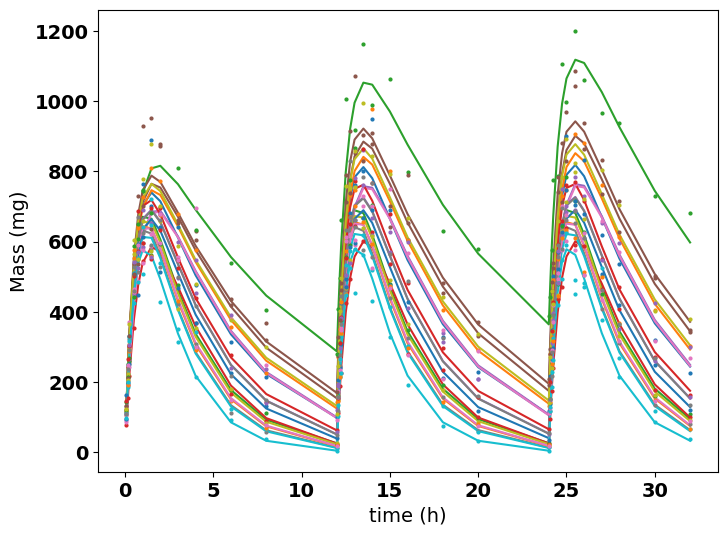

In [4]:
# Simulate some data
y_hat = ode_map_event(theta_patient)

sigma = 0.1
# NOTE: no observation at time t = 0.
log_y = sigma * random.normal(random.PRNGKey(1954), y_hat.shape) \
  + jnp.log(y_hat)
y_obs = jnp.exp(log_y)

figure(figsize = [8, 6])
plot(t[1:], y_hat)
plot(t[1:], y_obs, 'o', markersize = 2)
xlabel("time (h)")
ylabel("Mass (mg)")
show()

In [5]:
y_obs_np = np.array(y_obs)
np.save(deliv_dir + "pk_y_obs", y_obs_np)

### Run MCMC and generate golden benchmark

In [6]:
num_seed = 10
num_samples = 5
num_warmup, num_sampling = 5, 5  # 1000, 1000
total_samples = num_warmup + num_sampling
init_step_size = 0.001

kernel = construct_kernel(target_log_prob_fn = pop_target_log_prob_fn,
                          init_step_size = init_step_size,
                          num_warmup = num_warmup)

In [7]:
def trace_fn(current_state, pkr):
  return (
    # proxy for divergent transitions
    get_innermost(pkr, 'log_accept_ratio') < -1000,
    get_innermost(pkr, 'step_size'),
    get_innermost(pkr, 'max_trajectory_length')
  )


In [8]:
num_super_chains = 16
num_chains = 2048

In [9]:
initial_state = initialize((num_super_chains,))
for i in range(0, len(initial_state)):
  initial_state[i] = np.repeat(initial_state[i],
                               num_chains // num_super_chains, axis = 0)

In [10]:
mcmc_states, diverged = tfp.mcmc.sample_chain(
    num_results = total_samples,
    current_state = initial_state,
    kernel = kernel,
    trace_fn = trace_fn,
    seed = random.PRNGKey(1954))

In [11]:
# check inference
print("Divergent transitions after warmup:",
      np.sum(diverged[0][num_warmup:(num_warmup + num_samples)]))

Divergent transitions after warmup: 0


In [12]:
# Extract samples after warmup from the list
mcmc_states_sample = mcmc_states
for i in range(0, len(mcmc_states)):
  mcmc_states_sample[i] = mcmc_states[i][num_warmup:]

In [13]:
# NOTE: the last parameter is an 'x': not sure where this comes from...
parameter_names = pop_model._flat_resolve_names()[:-1]

az_states = az.from_dict(
    #prior = {k: v[tf.newaxis, ...] for k, v in zip(parameter_names, prior_samples)},
    posterior={
        k: np.swapaxes(v, 0, 1) for k, v in zip(parameter_names, mcmc_states)
    },
)

fit_summary = az.summary(az_states).filter(items=["mean", "sd", "mcse_sd", "hdi_3%",
                                       "hdi_97%", "ess_bulk", "ess_tail",
                                       "r_hat"])

In [14]:
# Plot summary table, check ESS and Rhat.
fit_summary

,mean,sd,mcse_sd,hdi_3%,hdi_97%,ess_bulk,ess_tail,r_hat
log_k1_pop,0.209,0.050,0.008,0.142,0.290,19.0,19.0,3.71
log_k2_pop,-1.472,0.053,0.009,-1.566,-1.424,19.0,19.0,2.36
log_scale_k1,-1.732,0.055,0.009,-1.794,-1.669,19.0,16.0,1.95
log_scale_k2,-1.205,0.144,0.024,-1.435,-1.065,19.0,19.0,4.30
log_sigma,-0.769,0.068,0.011,-0.899,-0.703,19.0,19.0,4.34
eta_k1[0],-0.774,0.692,0.113,-1.476,-0.082,19.0,19.0,2.94
eta_k1[1],-0.018,0.783,0.128,-0.788,0.776,19.0,19.0,3.23
eta_k1[2],-0.854,0.488,0.080,-1.380,-0.371,19.0,16.0,1.92
eta_k1[3],0.016,0.308,0.050,-0.305,0.371,19.0,19.0,4.17
eta_k1[4],0.942,0.631,0.103,0.314,1.594,19.0,16.0,2.73


In [32]:
num_dimensions = fit_summary.shape[0]
mean_est = np.zeros(num_dimensions)
var_est = np.zeros(num_dimensions)

for i in range(0, num_dimensions):
  mean_est[i] = fit_summary.iat[i, 0]
  var_est[i] = np.square(fit_summary.iat[i, 1])

In [34]:
# save benchmark values
file_prefix = deliv_dir + "pk_npatients_" + str(n_patients)
np.save(file_prefix + "_mean_est", mean_est)
np.save(file_prefix + "_var_est", var_est)